# Deep Learning models for predicting future trade Volume.

In this notebook, we will usually use normalized features and volume. The volume will be denormalized only for the purpose of model evaluation. We will use StandardScaler for normalization.

We can draw conclusion from the Exploratory Data Analysis that not all features from the original dataset are usefull for prediction and few more additional features can be added. Models in this notebook will work with usually with following columns:

| Feature  | Type | Description |
| ------------- | ------------- ||
| Volume X  | float64  |Historial trading volume shifted by X|
| AdjCloseDiff X  | float64  |Historical difference between AdjClose price of two consecutive days shifted by X|
| HighLowDiff X  | float64  |Historical difference between High and Low price shifted by X|
| DayOfWeek X  | one-hot |One-hot encoding value for each day|
| Month X  | one-hot  |One-hot encoding value for each month|

Le'ts now read the normalized data.

In [1]:
import tensorflow as tf
import numpy as np
import sys
import pandas as pd
import datetime

sys.path.append("../") # go to parent dir
from util.read_data import DataReader
from util.evaluator import ModelEvaluator
from util.visualizer import visialize_errors
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tf.enable_eager_execution()

In [2]:
# read test and train data
reader = DataReader()

df = reader.read_normalized_data_for_rnn('../data/S&P500.csv')
train_features, train_volume = reader.get_train_data(df)
# we can use the historical Volume as well
train_features['Volume'] = train_volume
test_features, test_volume = reader.get_test_data(df)
test_features['Volume'] = test_volume
evaluator = ModelEvaluator(reader.label_scaler)

In [3]:
class DataLoader():
    def __init__(self, features, volume):
        self.features = features
        self.volume = volume

    def get_batch(self, seq_length, batch_size):
        seq = []
        next_volume = []
        for i in range(batch_size):
            # the training example in batch has to be random 
            index = np.random.randint(0, len(self.volume) - seq_length)
            seq.append(self.features[index:index+seq_length].values)
            next_volume.append(self.volume[index+seq_length])
        return np.array(seq), np.array(next_volume).reshape(-1, 1)

# TODO should be refactored to predict in batches, not one by one
def predict_volume(rnn_model, features):
    volume_pred = []
    for i in range(len(features) - seq_length):
        x = features[i:i + seq_length]
        x = x.values.reshape(1, seq_length, x.shape[1])
        volume_pred.append(rnn_model(x).numpy()[0, 0])
    return pd.Series(volume_pred)

One of the DNN models successfull with the time series predictions is LSTM model. Le'ts implement it in Tensorflow.

In [4]:
class RNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # neither deep nor shallow
        self.cell1 = tf.nn.rnn_cell.BasicLSTMCell(num_units=512)
        self.cell2 = tf.nn.rnn_cell.BasicLSTMCell(num_units=512)
        self.dense1 = tf.keras.layers.Dense(units=1024)
        self.dense2 = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        batch_size, seq_length, _ = tf.shape(inputs)
        state1 = self.cell1.zero_state(batch_size=batch_size, dtype=tf.float32)
        state2 = self.cell2.zero_state(batch_size=batch_size, dtype=tf.float32)
        for t in range(seq_length.numpy()):
            output, state1 = self.cell1(inputs[:, t, :], state1)
            output, state2 = self.cell2(output, state2)
            output = self.dense1(output)
            output = self.dense2(output)
        return output

    def predict(self, inputs, temperature=1.):
        batch_size, _ = tf.shape(inputs)
        output = self(inputs)
        return output.numpy()


In [12]:
# TODO hyperparameters should be tuned, e.g. with http://hyperopt.github.io/hyperopt/
learning_rate = 1e-3
batch_size = 64
seq_length = 20
num_batches = 1000

In [13]:
data_loader = DataLoader(train_features,train_volume)
model = RNN()
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(seq_length, batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred)
        if (batch_index % 100 == 0):
            print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

batch 0: loss 1.061276
batch 100: loss 0.156878
batch 200: loss 0.078474
batch 300: loss 0.098252
batch 400: loss 0.165972
batch 500: loss 0.073750
batch 600: loss 0.109766
batch 700: loss 0.037252
batch 800: loss 0.176398
batch 900: loss 0.049851


In [14]:
lstm_result = evaluator.evaluate("lstm {} on test".format(seq_length), test_volume[seq_length:], 
                         predict_volume(model, test_features))
print(lstm_result)

lstm 20 on test: MSE = 2.475881e+17, R2 = 0.370, conf. int. 95% of error = (-76,688,832 - 12,247,342)


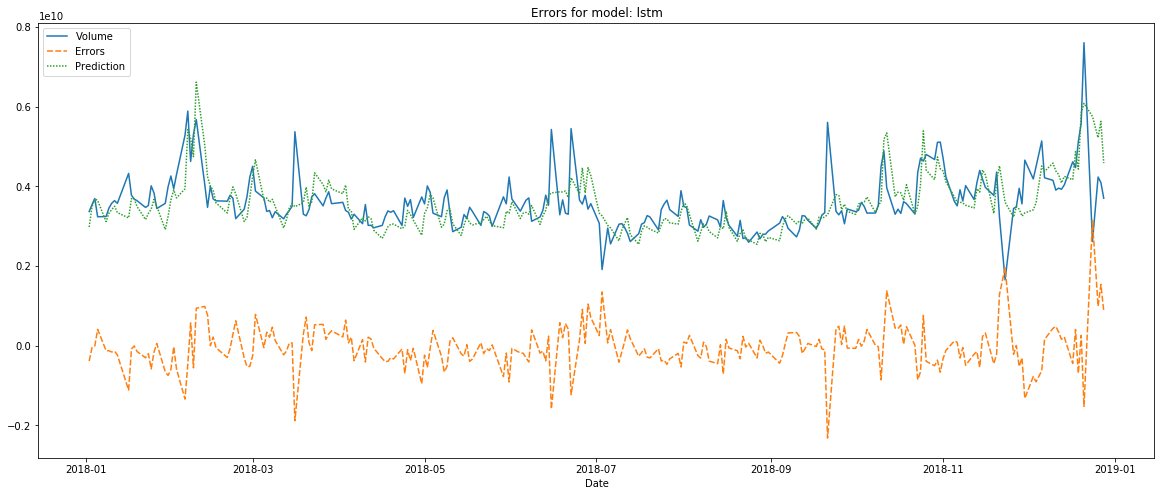

In [15]:
visialize_errors("lstm", lstm_result.volume_true, lstm_result.errors)

The best R2 score with LSTM model on the test set is similar to ML models, R2 score = 0.370.
The score could be improved with proper hyperparameter tuning, e.g. with http://hyperopt.github.io/hyperopt/.

Still, the length of the train data is probably not enough for Deep Learning model. Deep Learning works the best with a lot of data available. 